In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from hydro_forecasting.data.caravanify_parquet import (
    CaravanifyParquet,
    CaravanifyParquetConfig,
)

## Figuring out where most CA basins fall

In [2]:
path_to_classification_results = (
    "/Users/cooper/Desktop/hydro-forecasting/scripts/cluster_basins/classification_results/cluster_probabilities.csv"
)

df = pd.read_csv(path_to_classification_results)
df

,gauge_id,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob,cluster_8_prob,cluster_9_prob,cluster_10_prob,predicted_cluster,prediction_confidence
0,CA_15013,0.029938,0.121813,0.250048,0.044706,0.024446,0.022198,0.123016,0.258104,0.023778,0.032806,0.069147,7,0.258104
1,CA_15016,0.026778,0.068810,0.232778,0.023333,0.029365,0.019583,0.087528,0.403083,0.018317,0.035611,0.054813,7,0.403083
2,CA_15020,0.017778,0.046778,0.220560,0.036111,0.025667,0.013333,0.063532,0.473952,0.022540,0.034944,0.044806,7,0.473952
3,CA_15022,0.014722,0.051643,0.208687,0.039444,0.030548,0.011667,0.072135,0.456659,0.024802,0.044611,0.045083,7,0.456659
4,CA_15025,0.013611,0.051643,0.194726,0.036889,0.028095,0.015333,0.062476,0.480397,0.030746,0.036333,0.049750,7,0.480397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,CA_17329,0.016857,0.048484,0.240869,0.030426,0.017075,0.013722,0.032206,0.497659,0.038677,0.041595,0.022429,7,0.497659
74,CA_17338,0.034005,0.068623,0.222889,0.024944,0.024525,0.023556,0.042754,0.473545,0.021952,0.039056,0.024151,7,0.473545
75,CA_17344,0.038429,0.084290,0.214642,0.031833,0.021307,0.033302,0.081063,0.364472,0.045016,0.037040,0.048607,7,0.364472
76,CA_17453,0.012278,0.052460,0.240421,0.037815,0.012968,0.028437,0.047577,0.451307,0.027627,0.038556,0.050556,7,0.451307


In [3]:
def analyze_top_two_clusters(df):
    """
    Counts how often each cluster appears in the top 2 most confident predictions
    for each gauge_id.

    Args:
        df: DataFrame with cluster probability columns (cluster_0_prob to cluster_10_prob)

    Returns:
        Series with cluster counts in top 2 predictions
    """
    # Get probability columns
    prob_cols = [col for col in df.columns if col.startswith("cluster_") and col.endswith("_prob")]

    # For each row, find the top 2 clusters
    top_two_counts = {}
    for cluster_num in range(11):  # clusters 0-10
        top_two_counts[f"cluster_{cluster_num}"] = 0

    for _, row in df.iterrows():
        # Get top 2 cluster probabilities for this gauge
        probs = pd.to_numeric(row[prob_cols], errors="coerce")
        top_two_idx = probs.nlargest(2).index

        # Count occurrences
        for idx in top_two_idx:
            cluster_name = idx.replace("_prob", "")
            top_two_counts[cluster_name] += 1

    return pd.Series(top_two_counts).sort_values(ascending=False)

In [4]:
cluster_frequency = analyze_top_two_clusters(df)
print(cluster_frequency)

cluster_7     73
cluster_2     66
cluster_1     11
cluster_6      5
cluster_10     1
cluster_0      0
cluster_3      0
cluster_4      0
cluster_5      0
cluster_8      0
cluster_9      0
dtype: int64


In [5]:
def plot_top_two_clusters(df):
    """
    Creates a scatter plot showing the relationship between most confident
    and second most confident cluster predictions.

    Args:
        df: DataFrame with cluster probability columns (cluster_0_prob to cluster_10_prob)
    """
    # Get probability columns
    prob_cols = [col for col in df.columns if col.startswith("cluster_") and col.endswith("_prob")]

    # Store results
    results = []

    for _, row in df.iterrows():
        # Get top 2 cluster probabilities for this gauge
        probs = pd.to_numeric(row[prob_cols], errors="coerce")
        top_two = probs.nlargest(2)

        # Extract cluster numbers from column names
        most_confident = int(top_two.index[0].replace("cluster_", "").replace("_prob", ""))
        second_confident = int(top_two.index[1].replace("cluster_", "").replace("_prob", ""))

        results.append(
            {"gauge_id": row["gauge_id"], "most_confident": most_confident, "second_confident": second_confident}
        )

    # Convert to DataFrame and count combinations
    results_df = pd.DataFrame(results)
    combo_counts = results_df.groupby(["most_confident", "second_confident"]).size().reset_index(name="count")

    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=combo_counts, x="most_confident", y="second_confident", size="count", sizes=(50, 500), alpha=0.7
    )

    plt.xlabel("Most Confident Cluster")
    plt.ylabel("Second Most Confident Cluster")
    plt.title("Distribution of Top Two Cluster Predictions")
    plt.xticks(range(11))
    plt.yticks(range(11))
    plt.grid(True, alpha=0.3)
    plt.legend(title="Number of Gauges", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return combo_counts

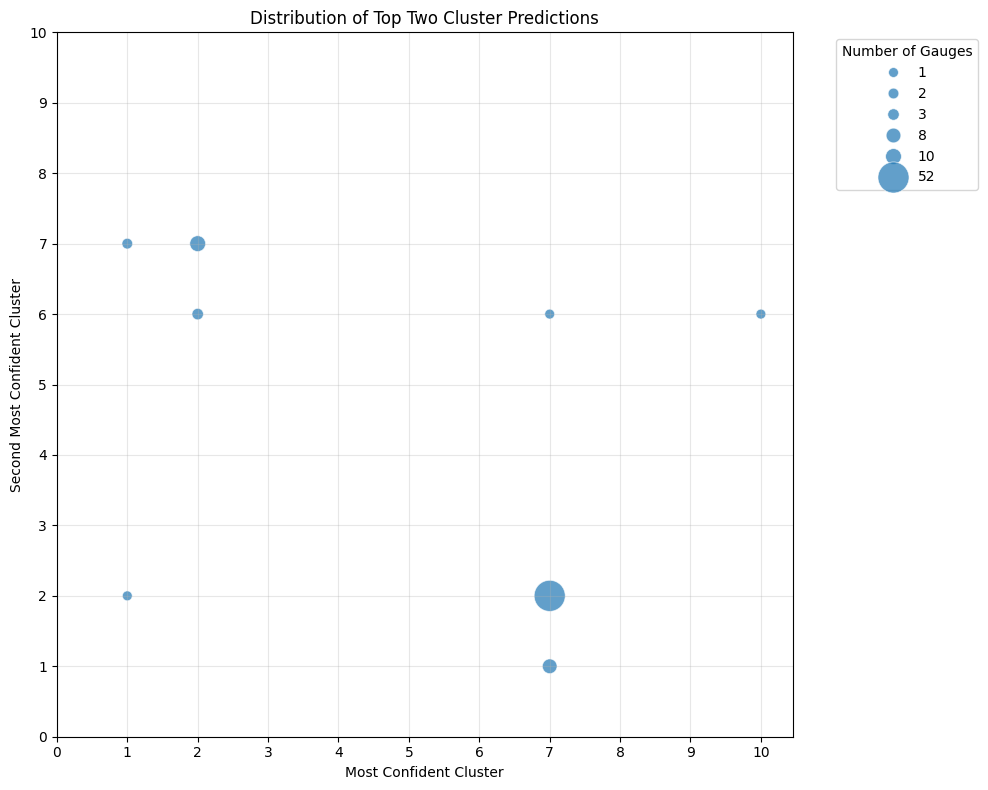

   most_confident  second_confident  count
0               1                 2      1
1               1                 7      2
2               2                 6      3
3               2                 7     10
4               7                 1      8
5               7                 2     52
6               7                 6      1
7              10                 6      1


In [6]:
combo_counts = plot_top_two_clusters(df)
print(combo_counts)

In [7]:
def count_basins_without_cluster_7_or_2(df):
    """
    Counts how many basins don't have cluster 7 or 2 in their top 2 most confident predictions.

    Args:
        df: DataFrame with cluster probability columns (cluster_0_prob to cluster_10_prob)

    Returns:
        dict with counts and details
    """
    # Get probability columns
    prob_cols = [col for col in df.columns if col.startswith("cluster_") and col.endswith("_prob")]

    # Store results
    basins_without_7_or_2 = []
    total_basins = len(df)

    for _, row in df.iterrows():
        # Get top 2 cluster probabilities for this gauge
        probs = pd.to_numeric(row[prob_cols], errors="coerce")
        top_two = probs.nlargest(2)

        # Extract cluster numbers from column names
        top_clusters = [int(idx.replace("cluster_", "").replace("_prob", "")) for idx in top_two.index]

        # Check if neither 7 nor 2 are in top 2
        if 7 not in top_clusters and 2 not in top_clusters:
            basins_without_7_or_2.append(
                {
                    "gauge_id": row["gauge_id"],
                    "most_confident": top_clusters[0],
                    "second_confident": top_clusters[1],
                    "top_two_clusters": top_clusters,
                }
            )

    count_without = len(basins_without_7_or_2)
    count_with = total_basins - count_without

    print(f"Total basins: {total_basins}")
    print(f"Basins WITH cluster 7 or 2 in top 2: {count_with}")
    print(f"Basins WITHOUT cluster 7 or 2 in top 2: {count_without}")
    print(f"Percentage without cluster 7 or 2: {count_without / total_basins * 100:.1f}%")

    if basins_without_7_or_2:
        print("\nBasins without cluster 7 or 2 in top 2:")
        for basin in basins_without_7_or_2:
            print(f"  {basin['gauge_id']}: clusters {basin['most_confident']} and {basin['second_confident']}")

    return {
        "total_basins": total_basins,
        "count_with_7_or_2": count_with,
        "count_without_7_or_2": count_without,
        "percentage_without": count_without / total_basins * 100,
        "basins_without_details": basins_without_7_or_2,
    }

In [8]:
result = count_basins_without_cluster_7_or_2(df)
print(result)

Total basins: 78
Basins WITH cluster 7 or 2 in top 2: 77
Basins WITHOUT cluster 7 or 2 in top 2: 1
Percentage without cluster 7 or 2: 1.3%

Basins without cluster 7 or 2 in top 2:
  CA_16143: clusters 10 and 6
{'total_basins': 78, 'count_with_7_or_2': 77, 'count_without_7_or_2': 1, 'percentage_without': 1.282051282051282, 'basins_without_details': [{'gauge_id': 'CA_16143', 'most_confident': 10, 'second_confident': 6, 'top_two_clusters': [10, 6]}]}


In [9]:
def plot_cluster_confidence_boxplot(df):
    """
    Creates a boxplot showing the distribution of confidence scores for clusters 2 and 7
    across all basins.

    Args:
        df: DataFrame with cluster probability columns
    """
    # Extract cluster 2 and 7 probabilities
    cluster_data = []

    for _, row in df.iterrows():
        cluster_data.append({"gauge_id": row["gauge_id"], "cluster": "Cluster 2", "confidence": row["cluster_2_prob"]})
        cluster_data.append({"gauge_id": row["gauge_id"], "cluster": "Cluster 7", "confidence": row["cluster_7_prob"]})

    # Convert to DataFrame
    plot_df = pd.DataFrame(cluster_data)
    plot_df["confidence"] = pd.to_numeric(plot_df["confidence"], errors="coerce")

    # Create boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=plot_df, x="cluster", y="confidence")

    plt.xlabel("Cluster")
    plt.ylabel("Confidence Score")
    plt.title("Distribution of Confidence Scores for Clusters 2 and 7")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    summary = plot_df.groupby("cluster")["confidence"].describe()
    print("Summary Statistics:")
    print(summary)

    return plot_df

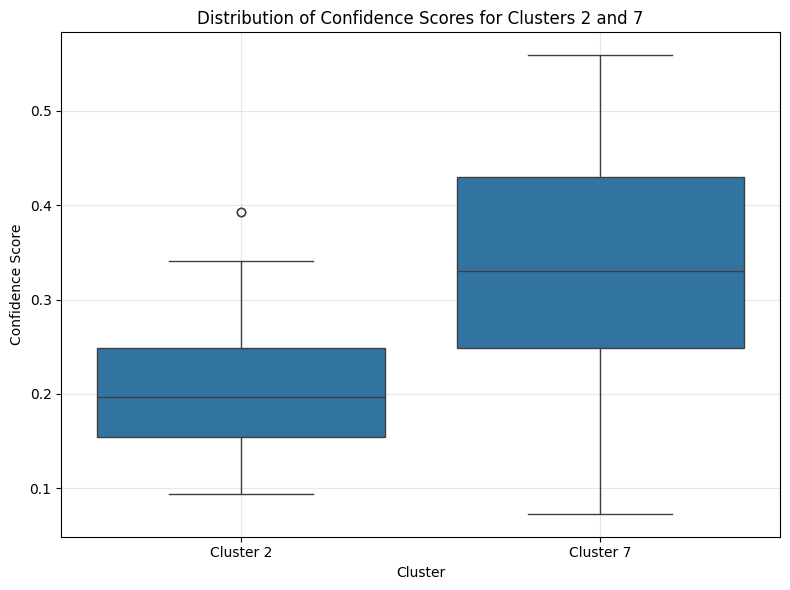

Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
cluster                                                                        
Cluster 2   78.0  0.205610  0.066262  0.094241  0.154284  0.196766  0.248129   
Cluster 7   78.0  0.333868  0.115786  0.072950  0.248448  0.329840  0.429744   

                max  
cluster              
Cluster 2  0.393217  
Cluster 7  0.558894  
   gauge_id    cluster  confidence
0  CA_15013  Cluster 2    0.250048
1  CA_15013  Cluster 7    0.258104
2  CA_15016  Cluster 2    0.232778
3  CA_15016  Cluster 7    0.403083
4  CA_15020  Cluster 2    0.220560


In [10]:
plot_data = plot_cluster_confidence_boxplot(df)
print(plot_data.head())

In [13]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


def plot_country_cluster_distribution(df, load_basin_ids_func):
    """
    Creates a stacked bar chart showing the distribution of Tajik and Kyrgyz basins
    in clusters 2 and 7.

    Args:
        df: DataFrame with gauge_id and predicted_cluster columns
        load_basin_ids_func: Function to load basin IDs for a given country
    """
    # Load basin IDs for each country
    tajik_basins = set(load_basin_ids_func("Tajikistan"))
    kyrgyz_basins = set(load_basin_ids_func("Kyrgyzstan"))

    # Filter dataframe for clusters 2 and 7 only
    cluster_df = df[df["predicted_cluster"].isin([2, 7])].copy()

    # Add country column
    def get_country(gauge_id):
        if gauge_id in tajik_basins:
            return "Tajikistan"
        elif gauge_id in kyrgyz_basins:
            return "Kyrgyzstan"
        else:
            return "Unknown"

    cluster_df["country"] = cluster_df["gauge_id"].apply(get_country)

    # Count basins by cluster and country
    counts = cluster_df.groupby(["predicted_cluster", "country"]).size().unstack(fill_value=0)

    # Create stacked bar chart
    plt.figure(figsize=(8, 6))

    # Define colors
    colors = ["#1f77b4", "#ff7f0e"]  # Blue for Tajikistan, Orange for Kyrgyzstan

    counts.plot(kind="bar", stacked=True, color=colors, width=0.6)

    plt.xlabel("Cluster")
    plt.ylabel("Number of Basins")
    plt.title("Distribution of Tajik and Kyrgyz Basins in Clusters 2 and 7")
    plt.xticks([0, 1], ["Cluster 2", "Cluster 7"], rotation=0)
    plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()

    # Print summary
    print("Basin counts by cluster and country:")
    print(counts)
    print(f"\nTotal basins in analysis: {counts.sum().sum()}")

    # Calculate percentages
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    print("\nPercentage breakdown:")
    print(percentages.round(1))

    return counts

<Figure size 800x600 with 0 Axes>

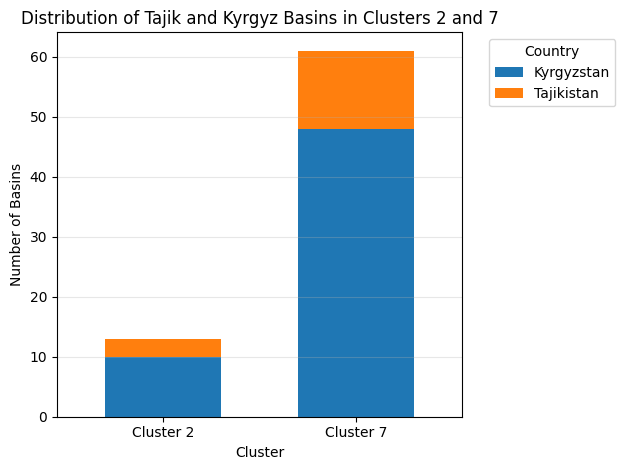

Basin counts by cluster and country:
country            Kyrgyzstan  Tajikistan
predicted_cluster                        
2                          10           3
7                          48          13

Total basins in analysis: 74

Percentage breakdown:
country            Kyrgyzstan  Tajikistan
predicted_cluster                        
2                        76.9        23.1
7                        78.7        21.3


In [15]:
counts = plot_country_cluster_distribution(df, load_basin_ids)

### Conclusion: cluster 7 and 2 are the most common clusters in the top 2 predictions.

## Checking out which countries are part of which clusters

In [16]:
path_to_clustering_results = "/Users/cooper/Desktop/hydro-forecasting/scripts/cluster_basins/clustering_results/cluster_assignments_shifted_refactor.csv"

cluster_df = pd.read_csv(path_to_clustering_results)
cluster_df

,gauge_id,cluster
0,CH_2009,7
1,CH_2011,7
2,CH_2016,2
3,CH_2018,2
4,CH_2019,7
...,...,...
16048,lamah_76184,8
16049,lamah_76185,3
16050,lamah_76266,8
16051,lamah_76276,1


In [17]:
# Count basins in clusters 2 and 7
cluster_2_count = (cluster_df["cluster"] == 2).sum()
cluster_7_count = (cluster_df["cluster"] == 7).sum()
total_2_and_7 = cluster_2_count + cluster_7_count

print(f"Basins in cluster 2: {cluster_2_count}")
print(f"Basins in cluster 7: {cluster_7_count}")
print(f"Total basins in clusters 2 and 7: {total_2_and_7}")

# Or you can use value_counts for a quick overview
print("\nAll cluster counts:")
print(cluster_df["cluster"].value_counts().sort_index())

Basins in cluster 2: 1914
Basins in cluster 7: 1015
Total basins in clusters 2 and 7: 2929

All cluster counts:
cluster
0     1178
1     3669
2     1914
3     1754
4      620
5     1480
6     1569
7     1015
8     1169
9      646
10    1039
Name: count, dtype: int64


In [18]:
def plot_all_clusters_by_country(cluster_df):
    """
    Creates a stacked bar chart showing the distribution of countries
    across all clusters (0-10).

    Args:
        cluster_df: DataFrame with gauge_id and cluster columns
    """

    # Extract country from gauge_id prefix
    def get_country_from_prefix(gauge_id):
        prefixes = ["CH", "CL", "USA", "camelsaus", "camelsgb", "camelsbr", "hysets", "lamah"]
        for prefix in prefixes:
            if gauge_id.startswith(prefix + "_"):
                return prefix
        return "Unknown"

    # Add country column
    df_copy = cluster_df.copy()
    df_copy["country"] = df_copy["gauge_id"].apply(get_country_from_prefix)

    # Count basins by cluster and country
    counts = df_copy.groupby(["cluster", "country"]).size().unstack(fill_value=0)

    # Create stacked bar chart
    plt.figure(figsize=(14, 8))

    # Use a color palette with enough distinct colors
    colors = plt.cm.Set3(range(len(counts.columns)))

    ax = counts.plot(kind="bar", stacked=True, color=colors, width=0.8, figsize=(14, 8))

    plt.xlabel("Cluster")
    plt.ylabel("Number of Basins")
    plt.title("Distribution of Countries Across All Clusters")
    plt.xticks(range(11), [f"Cluster {i}" for i in range(11)], rotation=45)
    plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()

    # Print summary
    print("Basin counts by cluster and country:")
    print(counts)
    print(f"\nTotal basins in analysis: {counts.sum().sum()}")

    # Show cluster totals
    cluster_totals = counts.sum(axis=1)
    print("\nTotal basins per cluster:")
    for cluster in range(11):
        if cluster in cluster_totals.index:
            print(f"Cluster {cluster}: {cluster_totals[cluster]}")
        else:
            print(f"Cluster {cluster}: 0")

    # Show country totals
    country_totals = counts.sum(axis=0)
    print("\nTotal basins per country:")
    print(country_totals.sort_values(ascending=False))

    return counts

<Figure size 1400x800 with 0 Axes>

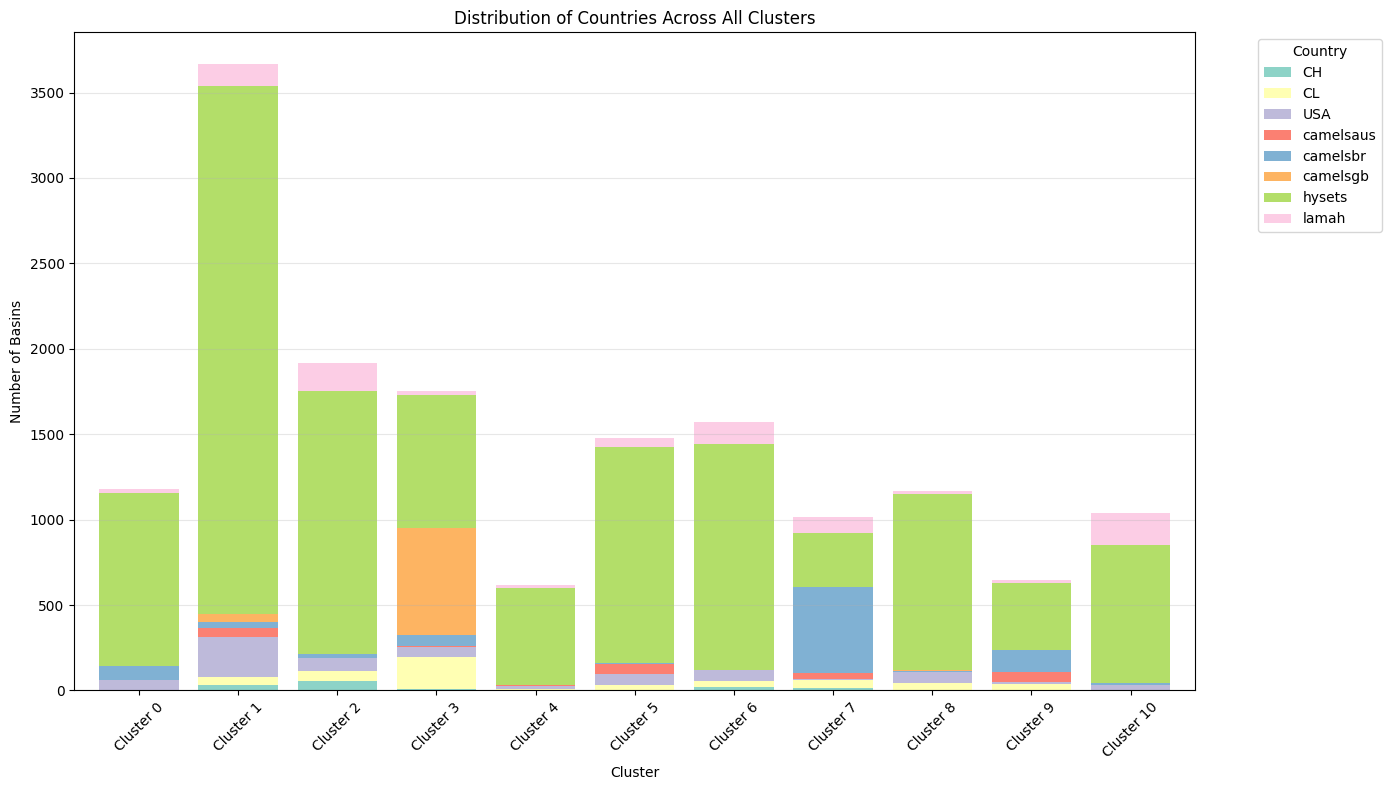

Basin counts by cluster and country:
country  CH   CL  USA  camelsaus  camelsbr  camelsgb  hysets  lamah
cluster                                                            
0         0    5   54          0        83         0    1012     24
1        34   45  233         51        40        42    3092    132
2        53   59   75          0        27         0    1536    164
3         9  187   56         11        61       624     779     27
4         0   11   14          6         3         0     566     20
5         0   33   62         62         1         2    1266     54
6        18   36   68          0         0         0    1323    124
7        16   44    7         34       506         0     315     93
8         2   43   63          2         6         2    1033     18
9         0   38   12         56       132         0     391     17
10        3    1   27          0        11         1     810    186

Total basins in analysis: 16053

Total basins per cluster:
Cluster 0: 1178
Clu

In [20]:
counts = plot_all_clusters_by_country(cluster_df)